In [1]:
# declare a list tasks whose products you want to use as inputs
upstream = None

In [2]:
# Parameters
product = {"nb": "/Users/macpro/Documents/GitHub/soZCqCfU4mL5ppCX/notebooks/train_model.ipynb"}


In [3]:
import pandas as pd
import os
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from pathlib import Path
from sklearn.utils import estimator_html_repr
import imgkit
import joblib
import imgkit
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def generate_pipeline(X, model):
    """
    
    This function generates a pipeline with preprocessing, and the classifier.

    Args:
        X (pandas.DataFrame): DataFrame containing the features
        model (sklearn model): Model to be used for classification

    Returns:
        pipeline (sklearn.pipeline.Pipeline): Pipeline with preprocessing,and the classifier
    """
    
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    # Define transformers for categorical and numerical columns
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_transformer = StandardScaler()

    # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Create a pipeline with preprocessing, SMOTE, and the classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', model)])
    
    return pipeline

In [5]:
def perform_cross_validation(X, y, pipeline, cv=5, scoring='accuracy', success_metric=0.81):

    """

    This function performs cross-validation and prints the average accuracy.

    Args:
        X (pandas.DataFrame): DataFrame containing the features
        y (pandas.Series): Series containing the target variable
        pipeline (sklearn.pipeline.Pipeline): Pipeline with preprocessing,and the classifier
        cv (int): Number of folds for cross-validation
        scoring (str): Metric to be used for cross-validation

    """

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)

    # Calculate the average accuracy
    avg_accuracy = cv_scores.mean()

    print("5-fold Cross-validation Accuracy:", avg_accuracy)

    if avg_accuracy >= success_metric:
        print("Success: The average accuracy is above or equal to the success metric.")
    else:
        print("Failure: The average accuracy is below the success metric.")

In [6]:
def save_model(pipeline):

    """

    This function saves the pipeline diagram and the pipeline sklearn object into the models folder

    Args:
        pipeline (sklearn.pipeline.Pipeline): Pipeline with preprocessing,and the classifier

    """

    # Save the pipeline diagram to a file
    result_path = os.path.abspath(os.path.join(os.getcwd(), 'models'))
    with open(Path(result_path, "pipeline_diagram.html"), "w") as f:
        f.write(estimator_html_repr(pipeline))

    # Convert the HTML to an image
    imgkit.from_file(str(Path(result_path, "pipeline_diagram.html")), str(Path(result_path, "pipeline_diagram.png")))

    # Save the pipeline to a file
    joblib.dump(pipeline, Path(result_path,"pipeline.joblib"))

In [7]:
def roc_curve_save_plot(pipeline, X_test, y_test):
    """
    
    This function generates a ROC curve and saves it to the figures folder.

    Args:
        pipeline (sklearn.pipeline.Pipeline): Pipeline with preprocessing,and the classifier
        X_test (pandas.DataFrame): DataFrame containing the features of the test set
        y_test (pandas.Series): Series containing the target variable of the test set

    """

    fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax_roc)
    DetCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax_det)

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")

    plt.legend()

    # save the plot as a file
    plt.savefig(os.path.abspath(os.path.join(os.getcwd(), 'reports', 'figures', "roc")))

In [8]:
def generate_feature_importances(pipeline,X, X_train, y_train):
    """
    
    This function generates a bar plot of feature importances and saves it to the figures folder.

    Args:
        pipeline (sklearn.pipeline.Pipeline): Pipeline with preprocessing,and the classifier
        X (pandas.DataFrame): DataFrame containing the features
        X_train (pandas.DataFrame): DataFrame containing the features of the training set
        y_train (pandas.Series): Series containing the target variable of the training set

    """

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Get feature importances
    importances = pipeline.named_steps['classifier'].feature_importances_

    # Get feature names
    numerical_feature_names = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=X.select_dtypes(include=['object']).columns.tolist())

    feature_names = numerical_feature_names + categorical_feature_names.tolist()

    # Create a dataframe with feature names and importances
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Sort the dataframe by feature importance
    feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)


    # Plot the feature importances
    plt.figure(figsize=(10, 10))
    sns.barplot(data=feature_importances, x='importance', y='feature')
    plt.title('Feature Importances')
    plt.savefig(os.path.abspath(os.path.join(os.getcwd(), 'reports', 'figures', 'feature-importances.png')))

5-fold Cross-validation Accuracy: 0.92875
Success: The average accuracy is above or equal to the success metric.


Accuracy: 0.9309166666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     11128
           1       0.55      0.26      0.36       872

    accuracy                           0.93     12000
   macro avg       0.75      0.62      0.66     12000
weighted avg       0.92      0.93      0.92     12000



Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


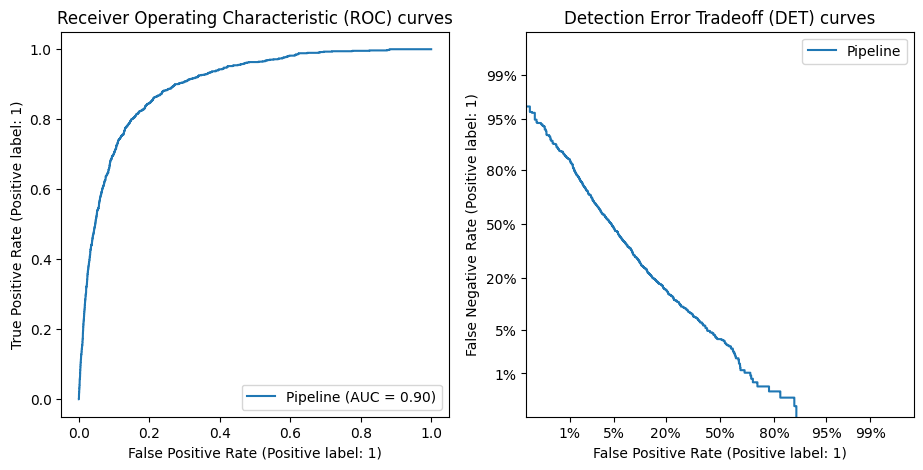

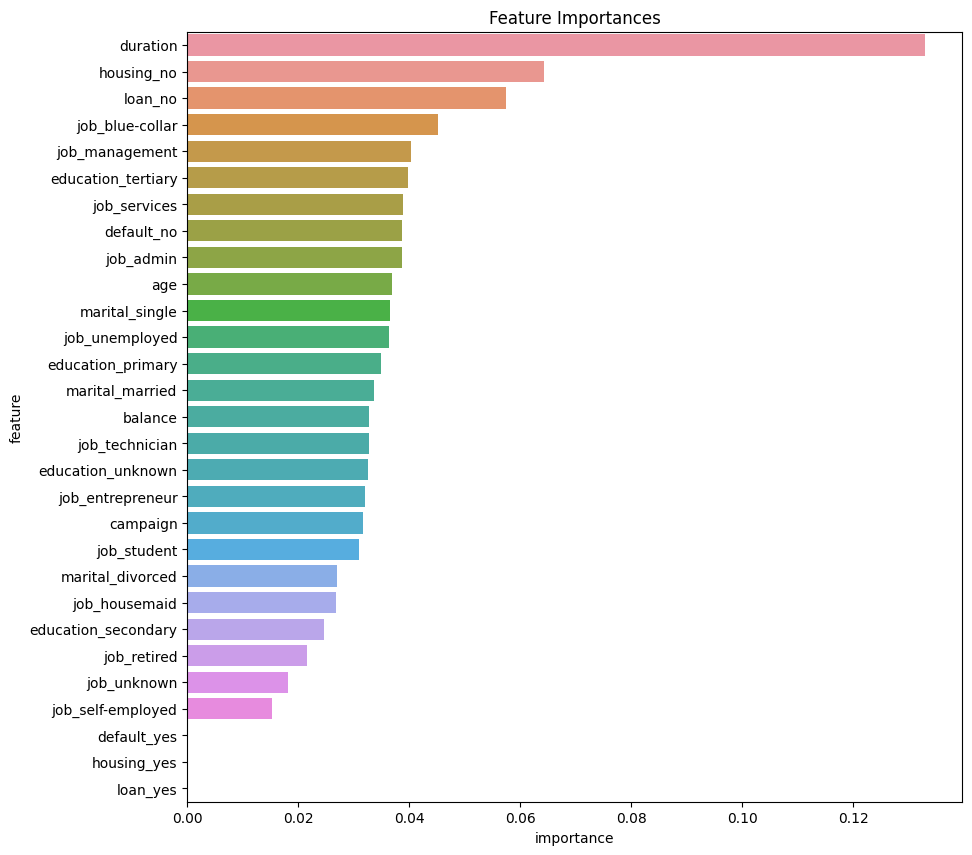

In [9]:
if __name__=="__main__":

    csv_path = os.path.abspath(os.path.join(os.getcwd(),  'data', 'raw', 'term-deposit-marketing-2020.csv'))
    data = pd.read_csv(csv_path)

    # Prepare target variable
    data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

    # Define feature columns and target column
    X = data.drop(columns=['y','month','day','contact'])
    y = data['y']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create a pipeline with preprocessing and XGBClassifier
    model = xgb.XGBClassifier(random_state=42, )
    pipeline = generate_pipeline(X, model)

    # Perform cross-validation
    perform_cross_validation(X_train, y_train, pipeline)

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Generate ROC curve
    roc_curve_save_plot(pipeline, X_test, y_test)

    # Generate feature importances
    generate_feature_importances(pipeline, X, X_train, y_train)

    # Save the model
    save_model(pipeline)